In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

### Load Data and Handle Missing Values

In [3]:
# Define file path
file_path = 'data/fec_data.csv'

# Load CSV file only if it exists
if os.path.exists(file_path):
    df = pd.read_csv(file_path, low_memory=False)
else:
    print(f"File not found at {file_path}. Please ensure the file exists.")

In [4]:
# Inspect dataset
df.head()

,committee_id,committee_name,report_year,report_type,image_number,line_number,transaction_id,file_number,committee_name.1,entity_type,...,filing_form,link_id,is_individual,memo_text,two_year_transaction_period,schedule_type,increased_limit,sub_id,pdf_url,line_number_label
0,C00010603,DNC SERVICES CORPORATION/DEMOCRATIC NATIONAL C...,2004,M10,24991281132,11AI,0014047824,144516,NaN,IND,...,F3X,4102120041043824694,t,NaN,2004,SA,NaN,4110920041045359865,http://docquery.fec.gov/cgi-bin/fecimg/?249912...,Contributions From Individuals/Persons Other T...
1,C00370114,CHARLES SCHWAB CORPORATION POLITICAL ACTION CO...,2004,Q3,24962526309,11AI,INC:A:53,140868,NaN,IND,...,F3X,4101520041043235350,t,NaN,2004,SA,NaN,4102320041043965652,http://docquery.fec.gov/cgi-bin/fecimg/?249625...,Contributions From Individuals/Persons Other T...
2,C00193433,EMILY'S LIST,2004,30G,25970298783,11AI,1709173,175907,NaN,IND,...,F3X,4060820051058138260,t,NaN,2004,SA,NaN,4060820051058158756,http://docquery.fec.gov/cgi-bin/fecimg/?259702...,Contributions From Individuals/Persons Other T...
3,C00364356,DAKPAC,2004,M4,24991123831,11AI,C219,117777,NaN,IND,...,F3X,4042020041037499949,t,NaN,2004,SA,NaN,4042320041037726959,http://docquery.fec.gov/cgi-bin/fecimg/?249911...,Contributions From Individuals/Persons Other T...
4,C00010603,DNC SERVICES CORPORATION/DEMOCRATIC NATIONAL C...,2004,30G,25990868363,11AI,0014949511,174209,NaN,IND,...,F3X,4051720051057403695,t,NaN,2004,SA,NaN,4053120051057894326,http://docquery.fec.gov/cgi-bin/fecimg/?259908...,Contributions From Individuals/Persons Other T...


In [4]:
# Check shape
df.shape

(89789, 79)

In [5]:
# Inspect years
df['report_year'].describe()

count    89789.000000
mean      2018.635122
std          3.911190
min       2003.000000
25%       2018.000000
50%       2020.000000
75%       2021.000000
max       2024.000000
Name: report_year, dtype: float64

Data extends from 2003-Present instead of 1979-Present (the FEC has mandated public disclosure of federal campaign contributions since its establishment in 1975 but database goes back to 1979) becuase occupation wasn't always a required field and dropping it and only filtering only by employer adds too much noise.

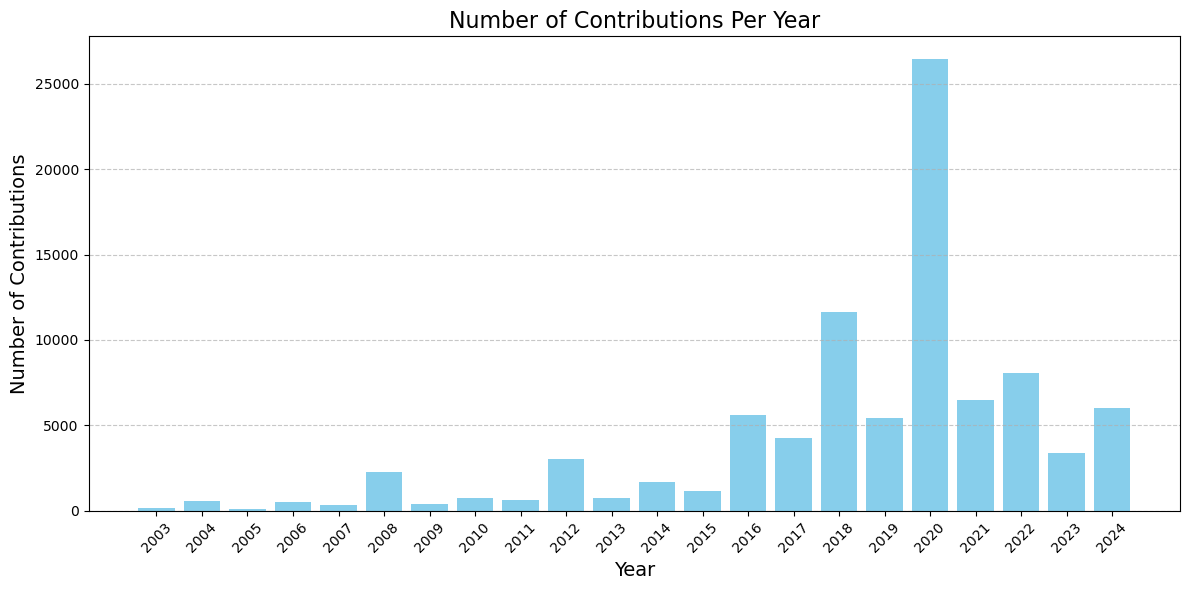

In [6]:
# Group data by report_year and count the number of contributions per year
contributions_per_year = df.groupby('report_year').size()

# Plot the contributions per year
plt.figure(figsize=(12, 6))
plt.bar(contributions_per_year.index, contributions_per_year.values, color='skyblue', width=0.8)
plt.title('Number of Contributions Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Contributions', fontsize=14)
plt.xticks(contributions_per_year.index, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Filter df to include only desired features
desired_features = [
'committee_id', 'file_number', 'committee_name', 'report_year',
        'contributor_name', 'recipient_committee_type', 'contributor_street_1',
        'contributor_street_2', 'contributor_city', 'contributor_state',
        'contributor_zip', 'contributor_employer', 'contributor_occupation',
        'contribution_receipt_date', 'contribution_receipt_amount',
]
df = df[desired_features]

In [8]:
# Check shape
df.shape

(89789, 15)

In [9]:
# Count missing values
df.isna().sum()

committee_id                       0
file_number                        0
committee_name                     0
report_year                        0
contributor_name                   2
recipient_committee_type           0
contributor_street_1              18
contributor_street_2           86142
contributor_city                   5
contributor_state                  7
contributor_zip                  251
contributor_employer               0
contributor_occupation             0
contribution_receipt_date          0
contribution_receipt_amount        0
dtype: int64

In [10]:
# Drop rows with missing required fields
df = df.dropna(subset=['contributor_name', 'contributor_street_1'])

# Define default values for optional fields
fill_values = {
    'contributor_street_2': '',
    'contributor_state': 'UNKNOWN',
    'contributor_city': 'UNKNOWN',
    'contributor_zip': '00000',
}

# Apply fillna
df = df.fillna(value=fill_values)

# Verify changes
df.isna().sum()

committee_id                   0
file_number                    0
committee_name                 0
report_year                    0
contributor_name               0
recipient_committee_type       0
contributor_street_1           0
contributor_street_2           0
contributor_city               0
contributor_state              0
contributor_zip                0
contributor_employer           0
contributor_occupation         0
contribution_receipt_date      0
contribution_receipt_amount    0
dtype: int64

#### Clean Data

In [11]:
# Dict to map state abbreviations to proper uppercase forms
state_abbreviations = {
    'ca': 'CA', 'ma': 'MA', 'nc': 'NC', 'nh': 'NH', 'ny': 'NY',
    'pa': 'PA', 'va': 'VA', 'wv': 'WV', 'wy': 'WY'
}

# Cleaning function for committee names
def clean_committee_name(name):
    
    # Apply title case
    name = name.title()

    # Remove ", The", ",DNC", ",DNC.", ", Inc.", ", Inc", "Inc." and "Inc"
    name = re.sub(r',?\s*(The|DNC\.?|Inc\.?)$', '', name, flags=re.IGNORECASE)

    # Capitalize the letter after "Mc"
    name = re.sub(r'\bMc([a-z])', lambda m: f"Mc{m.group(1).upper()}", name, flags=re.IGNORECASE)

    # Fix capitalization for specific words
    name = re.sub(r'\b(Of|For|To|21St|And)\b',
                  lambda x: x.group(0).lower(),
                  name,
                  flags=re.IGNORECASE)

    # Fix state abbreviations
    name = re.sub(r'\b(?:' + '|'.join(state_abbreviations.keys()) + r')\b',
              lambda m: state_abbreviations[m.group(0).lower()],
              name, flags=re.IGNORECASE)

    # Ensure acronyms are uppercase
    acronyms = [
        'AB', 'CHC', 'DAGA', 'DASS', 'DCCC', 'DGA', 'DNC', 'DSCC', 'DSI', 'FEC',
        'HMP', 'JD', 'JDCA', 'JFC', 'LCV', 'LPAC', 'MAD', 'MJ', 'NDTC', 'NRCC',
        'NRSC', 'PAC', 'RD', 'SCC', 'SD', 'SMP', 'US', 'VPP'
    ]
    for acronym in acronyms:
        name = re.sub(rf'\b{acronym}\b', acronym, name, flags=re.IGNORECASE)

    # Remove spaces between single uppercase letters (e.g., U S -> US)
    name = re.sub(r'\b([A-Z])\s+([A-Z])\b', r'\1\2', name)

    # Hardcode special cases
    replacements = {
        r'\bActblue\b': 'ActBlue',
        r'\bAmeripac: The Fund For Greater America\b': 'AmeriPAC: The Fund for Greater America',
        r'\bBill Keating Committee; The\b': 'Bill Keating Committee',
        r'\bBluewaveamerica\b': 'BlueWaveAmerica',
        r'\bDakpac\b': 'DakPAC',
        r'\bDIcc PAC\b': 'DICC PAC',
        r'\bDNC Services Corporation/Democratic National Committee\b': 'DNC Services Corp',
        r"\bDNC Services Corp\./Dem\. Nat('L|’L) Committee\b": "DNC Services Corp",
        r"\bEmily(?:['’]?)S List\b": "Emily's List",
        r'\bJstreetpac\b': 'JStreetPAC',
        r'\bKidspac\b': 'KidsPAC',
        r'\bLegitpac\b': 'Legit PAC',
        r'\bLessig2016\.Us\b': 'Lessig2016.us',
        r'\bL Pac\b': 'LPAC',
        r'\bMarkey Committee; The\b': 'Markey Committee',
        r'\bMccorkle For Colorado\b': 'McCorkle for Colorado',
        r'\bMcMullin For Utah\b': 'McMullin for Utah',
        r'\bMoveon\.Org PAC\b': 'MoveOn.org Political Action',
        r'\bMoveon\.Org Political Action\b': 'MoveOn.org Political Action',
        r'\bSoS America PAC\b': 'SOS America PAC',
        r'\bTulsi For Hawai’I\b': 'Tulsi for Hawaii',
        r'\bVotevets\b': 'VoteVets',
        r'\bWinred\b': 'WinRed'
    }
    for pattern, replacement in replacements.items():
        name = re.sub(pattern, replacement, name, flags=re.IGNORECASE)

    return name

# Apply cleaning function to committee_name
df['committee_name'] = df['committee_name'].apply(clean_committee_name)

In [12]:
# Convert remaining nonnumeric columns to proper capitlization
columns_to_title = ['contributor_name', 'contributor_street_1', 'contributor_street_2', 'contributor_city', 'contributor_employer', 'contributor_occupation']

for column in columns_to_title:
    df[column] = df[column].apply(lambda x: x.title() if isinstance(x, str) else x)

# Remove titles and middle initials
df['contributor_name'] = df['contributor_name'].str.replace(
    r'\b(Mr|Ms|Mrs|Dr|Prof|Mx)\.?\b|\b[A-Z]\.?\b', '', regex=True, case=False
).str.replace(r'\.', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()

# Fix directional abbreviations
df['contributor_street_1'] = df['contributor_street_1'].str.replace(
    r'\b(?:Nw|Ne|Sw|Se|N|S|E|W)\b',
    lambda m: m.group(0).upper(),
    regex=True
)

df['contributor_street_2'] = df['contributor_street_2'].str.replace(
    r'\b(?:Nw|Ne|Sw|Se|N|S|E|W)\b',
    lambda m: m.group(0).upper(),
    regex=True
)

In [13]:
# Inspect contributor_employer
df['contributor_employer'].value_counts()

contributor_employer
Harvard University                     59209
Harvard University - Cfa                8430
Harvard                                 7508
Harvard Law School                      3499
Harvard Business School                 2228
                                       ...  
Biogen/Harvard                             1
Bidmc-Harvard                              1
Harvard University & Kennedy School        1
Michigan/Harvard Law Schools               1
Harvard Unisversity                        1
Name: count, Length: 356, dtype: int64

In [14]:
# Set all values in contributor_employer to "Harvard University," since there's not sufficient heterogeneity in raw export to perform any meaningful slicing by Medical School, Law School, etc.
df['contributor_employer'] = "Harvard University"

In [ ]:
# Check out data
df['contribution_receipt_date'].

0      2004-09-27 00:00:00
1      2004-07-21 00:00:00
2      2004-11-01 00:00:00
3      2004-03-26 00:00:00
4      2004-10-25 00:00:00
              ...         
995    2005-09-28 00:00:00
996    2006-01-05 00:00:00
997    2006-03-16 00:00:00
998    2006-09-25 00:00:00
999    2005-12-23 00:00:00
Name: contribution_receipt_date, Length: 1000, dtype: object

In [16]:
# Investigate receipts
df['contribution_receipt_amount'].describe()

count     89769.000000
mean        176.588041
std        1128.227089
min       -8700.000000
25%           5.000000
50%          25.000000
75%         100.000000
max      100000.000000
Name: contribution_receipt_amount, dtype: float64

In [17]:
# Ensure contribution_receipt_date is in datetime format
df['contribution_receipt_date'] = pd.to_datetime(df['contribution_receipt_date'])

# Extract year from receipt date
df['report_year'] = df['contribution_receipt_date'].dt.year

# Group by contributor name and year, and calculate net contributions
net_contributions = df.groupby(['contributor_name', 'report_year'], as_index=False)['contribution_receipt_amount'].sum()

# Rename column for clarity
net_contributions.rename(columns={'contribution_receipt_amount': 'net_contributions'}, inplace=True)

# Display summary df
net_contributions.describe()

,report_year,net_contributions
count,7338.000000,7338.000000
mean,2015.593077,2160.279620
std,5.842848,7335.609262
min,2003.000000,-2300.000000
25%,2011.000000,175.000000
50%,2017.000000,500.000000
75%,2020.000000,1586.250000
max,2024.000000,195000.000000


In [18]:
# Filter for entries where net donations are less than 0
negative_net_donations = net_contributions[net_contributions['net_contributions'] < 0]

# Display all such instances
print(negative_net_donations)

# Count the number of such entries
print(f"Number of contributors with net negative donations: {len(negative_net_donations)}")

      contributor_name  report_year  net_contributions
2219  Goldsmith, Steve         2008            -2300.0
4740   Mnookin, Robert         2004            -2000.0
Number of contributors with net negative donations: 2


Upon further review, Mnookin donated $2000 to Clark for President Inc in 2003 and refunded that donation in 2004. Goldsmith donated $4600 to Rudy Giuliani Presidential Committee Inc in 2007 and refunded $2300 of it in 2008.

In [19]:
# Adjust the specific entries for Goldsmith
net_contributions.loc[(net_contributions['contributor_name'] == 'Goldsmith, Steve') & 
                      (net_contributions['report_year'] == 2007), 'net_contributions'] = 2300
net_contributions.loc[(net_contributions['contributor_name'] == 'Goldsmith, Steve') & 
                      (net_contributions['report_year'] == 2008), 'net_contributions'] = 0

# Adjust the specific entries for Mnookin
net_contributions.loc[(net_contributions['contributor_name'] == 'Mnookin, Robert') & 
                      (net_contributions['report_year'] == 2003), 'net_contributions'] = 0
net_contributions.loc[(net_contributions['contributor_name'] == 'Mnookin, Robert') & 
                      (net_contributions['report_year'] == 2004), 'net_contributions'] = 0

# Verify changes
negative_net_donations = net_contributions[net_contributions['net_contributions'] < 0]
print(f"Number of contributors with net negative donations: {len(negative_net_donations)}")

Number of contributors with net negative donations: 0


In [20]:
# Need to explore negative values further but let's use Professor Waldo as a test example
jim_waldo_data = df[df['contributor_name'].str.contains('Waldo, James', case=False, na=False)]

# Check number of contributions
print(f"Number of contributions by Jim Waldo: {len(jim_waldo_data)}")

# Summarize contributions
jim_waldo_summary = jim_waldo_data.groupby('report_year')['contribution_receipt_amount'].sum()
print(jim_waldo_summary)

Number of contributions by Jim Waldo: 15
report_year
2020    548.0
2021     25.0
2022    150.0
2024    520.0
Name: contribution_receipt_amount, dtype: float64


In [21]:
# Save cleaned df to CSV file
df.to_csv('data/cleaned_fec_data.csv', index=False)